In [1]:
import numpy as np
from scipy.linalg import expm, logm

SigX = np.array([[0, 1], [1, 0]])
SigY = np.array([[0, -1j], [1j, 0]])
SigZ = np.array([[1, 0], [0, -1]])
SigI = np.array([[1, 0], [0, 1]])

pauli_basis_2q = [
    np.kron(SigI, SigI),
    np.kron(SigI, SigX),
    np.kron(SigI, SigY),
    np.kron(SigI, SigZ),
    np.kron(SigX, SigI),
    np.kron(SigX, SigX),
    np.kron(SigX, SigY),
    np.kron(SigX, SigZ),
    np.kron(SigY, SigI),
    np.kron(SigY, SigX),
    np.kron(SigY, SigY),
    np.kron(SigY, SigZ),
    np.kron(SigZ, SigI),
    np.kron(SigZ, SigX),
    np.kron(SigZ, SigY),
    np.kron(SigZ, SigZ),
]

len(pauli_basis_2q)


16

In [2]:
ux1 = np.kron(expm(-1j * np.pi / 4 * SigX), SigI)
ux2 = np.kron(SigI, expm(-1j * np.pi / 4 * SigX))
uz1 = np.kron(expm(-1j * np.pi / 4 * SigZ), SigI)
uz2 = np.kron(SigI, expm(-1j * np.pi / 4 * SigZ))
uy1 = np.kron(expm(-1j * np.pi / 4 * SigY), SigI)
uy2 = np.kron(SigI, expm(-1j * np.pi / 4 * SigY))

In [3]:
def model_CZ(x):
    generator = np.zeros((4, 4), dtype=complex)
    generator += (np.pi/2)*(pauli_basis_2q[3] + pauli_basis_2q[12]) - np.pi/2*(pauli_basis_2q[15] + pauli_basis_2q[0])
    for i in range(15):
        generator += x[i]*pauli_basis_2q[i+1]
    return expm(-(1j/2)*generator)

In [4]:
def germ_to_unitary(germ, params):
    u = np.eye(4)
    for gate in germ: 
        if gate == 'I':
            u = np.eye(4) @ u
        elif gate == 'X1': 
            u = ux1 @ u
        elif gate == 'X2':
            u = ux2 @ u
        elif gate == 'Z1':
            u = uz1 @ u
        elif gate == 'Z2':
            u = uz2 @ u
        elif gate == 'Y1':
            u = uy1 @ u
        elif gate == 'Y2':
            u = uy2 @ u
        elif gate == 'CZ':
            u = model_CZ(params) @ u
        else:
            raise ValueError('Invalid gate')
    return u

def germ_to_target(germ):
    return germ_to_unitary(germ, np.zeros(15))


In [5]:
cartan_basis = [
    np.diag([1, -1, 0, 0]), 
    np.diag([0, 1, -1, 0]), 
    np.diag([0, 0, 1, -1]), 
]

def rectify_phase(phase):
    return np.mod(phase, 2*np.pi)

def extract_eigen_phases(germ, params): 
    target_u = germ_to_target(germ)
    evals_targ, evecs_targ = np.linalg.eig(target_u)
    evec_targ_list = [evecs_targ[:,i] for i in range(4)]
    model_u = germ_to_unitary(germ, params)
    ephases = np.zeros(4)
    for idx, evec in enumerate(evec_targ_list):
        eval_approx = np.dot(evec.conj().T, model_u @ evec)
        ephases[idx] = np.real(1j*np.log(eval_approx))
    return ephases

def extract_cartan_params(germ, params, cartan_basis=cartan_basis):
    eigen_phases = extract_eigen_phases(germ, params)
    cartan_params = np.zeros(3)
    for i in range(3):
        cartan_params[i] = np.sum(cartan_basis[i] @ eigen_phases)
    return cartan_params

def extract_cartan_jacob(germ, epsilon=1e-6, cartan_basis=cartan_basis):
    target_u = germ_to_target(germ)
    evals_targ, evecs_targ = np.linalg.eig(target_u)
    evec_targ_list = [evecs_targ[:,i] for i in range(4)]
    jacob = np.zeros((3, 15))
    for i in range(15):
        params_plus = np.array([epsilon if j == i else 0 for j in range(15)])
        params_minus = np.array([-epsilon if j == i else 0 for j in range(15)])
        cartan_plus = extract_cartan_params(germ, params_plus)
        cartan_minus = extract_cartan_params(germ, params_minus)
        cartandiff = np.mod(cartan_plus - cartan_minus, 2*np.pi)
        if cartandiff[0] > np.pi:
            cartandiff[0] -= 2*np.pi
        if cartandiff[1] > np.pi:
            cartandiff[1] -= 2*np.pi
        if cartandiff[2] > np.pi:
            cartandiff[2] -= 2*np.pi
        #print(cartan_plus, cartan_minus, cartandiff)
        jacob[: ,i] = cartandiff/(2*epsilon)
    return jacob

In [6]:
extract_cartan_jacob(['CZ', 'X1', 'X2', 'Y1'])

array([[ 7.07045222e-03,  0.00000000e+00,  3.80422607e-01,
         3.92557869e-01,  4.08677214e-01, -2.73650482e-01,
         4.35078333e-01,  3.92557869e-01,  4.08677214e-01,
         2.73650482e-01,  4.35078333e-01, -4.47213595e-01,
        -4.77298654e-01,  0.00000000e+00,  2.35114101e-01],
       [ 5.23030440e-01,  0.00000000e+00, -1.45308506e-01,
        -1.18907387e-01, -1.11836934e-01,  5.03699773e-01,
        -2.64011191e-02, -1.18907387e-01, -1.11836934e-01,
        -5.03699773e-01, -2.64011191e-02,  0.00000000e+00,
         7.08042975e-01,  1.11022302e-10, -6.15536707e-01],
       [ 7.07045233e-03,  0.00000000e+00,  3.80422606e-01,
         2.30049291e-01, -3.23241399e-01, -1.11141904e-01,
        -2.96840279e-01,  2.30049291e-01, -3.23241399e-01,
         1.11141904e-01, -2.96840279e-01,  4.47213595e-01,
        -4.77298654e-01,  0.00000000e+00,  2.35114101e-01]])

In [7]:
def calc_frame_potential(frame):
    fpot = 0
    for row1 in frame:
        for row2 in frame:
            fpot += np.abs(np.dot(row1.conj().T, row2))**2
    return fpot

In [8]:
frame = extract_cartan_jacob(['CZ'])
print(frame)
fpot = calc_frame_potential(frame)
print(fpot)

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]]
16.000000005032007


In [9]:
germ_set_start = [['CZ', 'Z1', 'Z2']]


In [10]:
from itertools import product

In [11]:
gateset = ['CZ', 'X1', 'X2', 'Y1', 'Y2', 'Z1', 'Z2', 'I']
all_germ_choices = list(product(gateset, repeat=4))

In [12]:
def remove_germs_without_cz(all_germ_choices):
    germ_set = []
    for germ in all_germ_choices:
        if 'CZ' in germ:
            germ_set.append(germ)
    return germ_set

In [13]:
from tqdm import tqdm

In [14]:
def find_best_germ(prior_frame, germ_set): 
    best_germ = None
    best_fpot = np.inf
    for germ in germ_set:
        jacob = extract_cartan_jacob(germ)
        new_frame = np.vstack([jacob, prior_frame])
        new_fpot = calc_frame_potential(new_frame)
        if new_fpot < best_fpot:
            best_fpot = new_fpot
            best_germ = germ
    return best_germ, best_fpot

In [15]:
all_germ_choices = remove_germs_without_cz(all_germ_choices)
print(len(all_germ_choices))

1695


In [16]:
starting_frame = extract_cartan_jacob(['CZ'])
find_best_germ(starting_frame, all_germ_choices)

(('CZ', 'X2', 'X2', 'X1'), 25.399300734274846)

In [18]:
def find_full_germ_set(starting_germ_set, all_germs, num_germs):
    germ_set = starting_germ_set
    frame = np.vstack([extract_cartan_jacob(germ_set[i]) for i in range(len(germ_set))])
    for i in tqdm(range(num_germs)):
        best_germ, best_fpot = find_best_germ(frame, all_germs)
        germ_set.append(best_germ)
        frame = np.vstack([extract_cartan_jacob(germ_set[i]) for i in range(len(germ_set))])
    return germ_set

In [19]:
optimal_germs = find_full_germ_set([['CZ', 'Z1', 'Z1', 'Z2']], all_germ_choices, 4)

100%|██████████| 4/4 [01:17<00:00, 19.43s/it]


In [20]:
optimal_frame = np.vstack([extract_cartan_jacob(germ) for germ in optimal_germs])

In [21]:
np.linalg.matrix_rank(optimal_frame)

14

In [22]:
calc_frame_potential(optimal_frame)

65.5915434244851

In [23]:
optimal_germs

[['CZ', 'Z1', 'Z1', 'Z2'],
 ('CZ', 'X2', 'X2', 'X1'),
 ('Y2', 'Y2', 'X1', 'CZ'),
 ('X2', 'Y1', 'CZ', 'Y2'),
 ('CZ', 'X1', 'X1', 'Y2')]

In [24]:
def construct_inphase_state_prep_vectors(evecs_list_input):
    psi01 = (evecs_list_input[0] + evecs_list_input[1])/np.sqrt(2)
    psi12 = (evecs_list_input[1] + evecs_list_input[2])/np.sqrt(2)
    psi23 = (evecs_list_input[2] + evecs_list_input[3])/np.sqrt(2)
    return psi01, psi12, psi23

def construct_quadrature_state_prep_vectors(evecs_list_input):
    psi01 = (evecs_list_input[0] + 1j*evecs_list_input[1])/np.sqrt(2)
    psi12 = (evecs_list_input[1] + 1j*evecs_list_input[2])/np.sqrt(2)
    psi23 = (evecs_list_input[2] + 1j*evecs_list_input[3])/np.sqrt(2)
    return psi01, psi12, psi23

In [25]:
evecs_targ = np.linalg.eig(germ_to_target(optimal_germs[0]))[1]
evec_targ_list = [evecs_targ[:,i] for i in range(4)]
construct_inphase_state_prep_vectors(evec_targ_list)

(array([0.70710678+0.j, 0.70710678+0.j, 0.        +0.j, 0.        +0.j]),
 array([0.        +0.j, 0.70710678+0.j, 0.70710678+0.j, 0.        +0.j]),
 array([0.        +0.j, 0.        +0.j, 0.70710678+0.j, 0.70710678+0.j]))

In [26]:
construct_quadrature_state_prep_vectors(evec_targ_list)

(array([0.70710678+0.j        , 0.        +0.70710678j,
        0.        +0.j        , 0.        +0.j        ]),
 array([0.        +0.j        , 0.70710678+0.j        ,
        0.        +0.70710678j, 0.        +0.j        ]),
 array([0.        +0.j        , 0.        +0.j        ,
        0.70710678+0.j        , 0.        +0.70710678j]))

In [27]:
np.linalg.eig(germ_to_target(['CZ']))

(array([ 1.+0.0000000e+00j,  1.+0.0000000e+00j,  1.+0.0000000e+00j,
        -1.+1.2246468e-16j]),
 array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]))

In [28]:
# compare the eigenvalues of the target unitary to the eigenvalues of the model unitary
x = 0.00001*np.random.randn(15)
model_u = germ_to_unitary(['CZ'], x)
target_u = germ_to_target(['CZ'])
evals_model, evecs_model = np.linalg.eig(model_u)
evals_targ, evecs_targ = np.linalg.eig(target_u)
print(abs(evecs_model[-1] - evecs_targ[0]))
print(abs(evecs_model[1] - evecs_targ[1]))
print(abs(evecs_model[2] - evecs_targ[2]))
print(abs(evecs_model[0] - evecs_targ[-1]))

[1.59179336e-11 5.27266363e-06 1.50928580e-06 1.32553471e-06]
[2.57661988e-06 3.59925365e-01 4.97278387e-01 5.85677956e-01]
[4.09980353e-06 5.13932216e-01 5.64765110e-01 6.91622408e-01]
[2.89630949e-06 5.71120074e-01 7.03691754e-01 1.38168209e+00]


In [29]:
evecs_model

array([[-2.71980894e-06+9.95614356e-07j,  1.05986232e-01+5.61199659e-01j,
         7.03691754e-01+0.00000000e+00j, -3.65202817e-01+2.12759675e-01j],
       [ 7.24585001e-07+2.47263960e-06j,  6.40074635e-01+0.00000000e+00j,
         2.46483840e-01+4.31892939e-01j,  4.27426899e-01-4.00405936e-01j],
       [-2.30563536e-06-3.39004935e-06j, -5.12243818e-01-4.16244332e-02j,
         4.69286246e-01-1.93138657e-01j,  6.91622408e-01+0.00000000e+00j],
       [ 1.00000000e+00+0.00000000e+00j, -2.05642096e-06+4.85511222e-06j,
         1.09464643e-06-1.03908268e-06j,  1.06987306e-06-7.82568785e-07j]])

# Verifying the design

In [30]:
import matplotlib.pyplot as plt
from quapack.pyRPE import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q as _rpeQ

In [31]:
def make_vandermont_vector(omega, depths, decay=0.0):
        return np.exp(-decay*depths - 1j*omega*depths)

def music_norm(vander_vec, noise_subspace):
    norm = 1/(vander_vec.conj().T @ noise_subspace @ noise_subspace.conj().T @ vander_vec)
    return norm.real

class MusicSpectrum:
    def __init__(self, cos_prob_series, sin_prob_series, depths, num_sources=1, decay=0.0, res=1000):
        self.signal = (1 - 2*cos_prob_series) + 1j*(1 - 2*sin_prob_series)
        self.depths = np.array(depths)
        self.num_sources = num_sources
        self.decay = decay
        self.res = res

    def show_spectrum_at_max_depth_idx(self, max_depth_idx=-1):
        omega = np.linspace(-np.pi, np.pi, self.res)
        noise_subspace = self.make_noise_subspace_matrix()
        music_spectrum = np.zeros(len(omega))
        for idx, o in enumerate(omega):
            vander_vec = make_vandermont_vector(o, self.depths)
            music_spectrum[idx] = music_norm(vander_vec, noise_subspace)
        plt.plot(omega, music_spectrum)
        plt.xlabel('omega')
        plt.ylabel('music spectrum')
        plt.show()


    def make_noise_subspace_matrix(self):
        cmat = np.outer(self.signal, np.conj(self.signal)) 
        evals, evecs = np.linalg.eig(cmat)
        # the noise subspace is the eigenvectors corresponding to all but the largest num_sources eigenvalues
        # remove the largest eigenvalue -- they are not sorted
        for i in range(self.num_sources):
            eval_norms = np.abs(evals)
            max_idx = np.argmax(eval_norms)
            # remove the max index
            evals = np.delete(evals, max_idx)
            evecs = np.delete(evecs, max_idx, axis=1)
        return evecs

    

In [32]:
def make_prob_series(params, germ, depths):
    evecs = np.linalg.eig(germ_to_target(germ))[1]
    evecs_list = [evecs[:,i] for i in range(4)]
    psi01, psi12, psi23 = construct_inphase_state_prep_vectors(evecs_list)
    print(psi01, psi12, psi23)
    psi01_q, psi12_q, psi23_q = construct_quadrature_state_prep_vectors(evecs_list)
    print(psi01_q, psi12_q, psi23_q)
    noisy_germ = germ_to_unitary(germ, params)
    probs_inphase = np.zeros((3, len(depths)))
    probs_quadrature = np.zeros((3, len(depths)))
    for idx, d in enumerate(depths): 
        probs_inphase[0, idx] = np.abs(np.dot(psi01.conj().T, np.linalg.matrix_power(noisy_germ, d) @ psi01))**2
        probs_inphase[1, idx] = np.abs(np.dot(psi12.conj().T, np.linalg.matrix_power(noisy_germ, d) @ psi12))**2
        probs_inphase[2, idx] = np.abs(np.dot(psi23.conj().T, np.linalg.matrix_power(noisy_germ, d) @ psi23))**2
        probs_quadrature[0, idx] = np.abs(np.dot(psi01.conj().T, np.linalg.matrix_power(noisy_germ, d) @ psi01_q))**2
        probs_quadrature[1, idx] = np.abs(np.dot(psi12.conj().T, np.linalg.matrix_power(noisy_germ, d) @ psi12_q))**2
        probs_quadrature[2, idx] = np.abs(np.dot(psi23.conj().T, np.linalg.matrix_power(noisy_germ, d) @ psi23_q))**2
    # clip to [0, 1]
    probs_inphase = np.clip(probs_inphase, 0, 1)
    probs_quadrature = np.clip(probs_quadrature, 0, 1)
    return probs_inphase.real, probs_quadrature.real
    

def sample_from_prob_series(prob_series, num_shots):
    """Binomial sampling from a probability series"""
    count_series = np.zeros(len(prob_series))
    for i in range(prob_series.shape[0]):
        count_series[i] = np.sum(np.random.binomial(num_shots, prob_series[i]))
    return count_series

def make_rpe_estimate_from_counts(inphase_counts, quad_counts, num_counts_per_circ, depths):
    experiment = _rpeQ()
    for idx, d in enumerate(depths):
        if d == 0:
            continue
        experiment.process_cos(d, (int(inphase_counts[idx]), int(num_counts_per_circ-inphase_counts[idx])))
        experiment.process_sin(d, (int(num_counts_per_circ-quad_counts[idx]), int(quad_counts[idx])))
    analysis = RobustPhaseEstimation(experiment)
    last_good_generation = analysis.check_unif_local(historical=True)
    estimates = analysis.angle_estimates
    return estimates, last_good_generation

def estimate_cartan_coefs_of_germ(params, germ, depths, counts):
    probs_inphase, probs_quadrature = make_prob_series(params, germ, depths)
    all_estimates = []
    all_lggs = []
    for i in range(3): 
        inphase_counts = sample_from_prob_series(probs_inphase[i], counts)
        quad_counts = sample_from_prob_series(probs_quadrature[i], counts)
        estimates, last_good_generation = make_rpe_estimate_from_counts(inphase_counts, quad_counts, counts, depths)
        all_estimates.append(estimates)
        all_lggs.append(last_good_generation)
    return all_estimates, all_lggs


In [33]:
optimal_germs[0]

['CZ', 'Z1', 'Z1', 'Z2']

In [34]:
estimate_cartan_coefs_of_germ(0.01*np.random.randn(15), optimal_germs[0], [2**i for i in range(22)], 1000)

[0.70710678+0.j 0.70710678+0.j 0.        +0.j 0.        +0.j] [0.        +0.j 0.70710678+0.j 0.70710678+0.j 0.        +0.j] [0.        +0.j 0.        +0.j 0.70710678+0.j 0.70710678+0.j]
[0.70710678+0.j         0.        +0.70710678j 0.        +0.j
 0.        +0.j        ] [0.        +0.j         0.70710678+0.j         0.        +0.70710678j
 0.        +0.j        ] [0.        +0.j         0.        +0.j         0.70710678+0.j
 0.        +0.70710678j]


([array([1.52083793, 1.51404134, 1.54632568, 1.54319273, 1.54992231,
         1.54871332, 1.54625263, 1.54275698, 1.54214463, 1.54151351,
         1.54312844, 1.54337722, 1.54359184, 1.54343657, 1.54341632,
         1.54343295, 1.54340841, 1.54340837, 1.5434088 , 1.54340732,
         1.54340957, 1.54340992]),
  array([1.55279827, 1.54182878, 1.56479748, 1.57004181, 1.57386135,
         1.57269616, 1.57856731, 1.58378271, 1.58025599, 1.57864601,
         1.57885502, 1.57898575, 1.57903478, 1.57891921, 1.57895361,
         1.57893931, 1.57896301, 1.57896297, 1.57896235, 1.57896234,
         1.57896077, 1.5789618 ]),
  array([4.71038898, 4.71838869, 4.70636605, 4.71715574, 4.71743504,
         4.72244369, 4.7241241 , 4.72669564, 4.72562753, 4.72697431,
         4.72565327, 4.7253287 , 4.72515597, 4.72499796, 4.72500619,
         4.72492735, 4.72492931, 4.72492905, 4.72492982, 4.72492908,
         4.72492746, 4.72492859])],
 [11, 20, 14])

In [35]:
probs_inphase, probs_quadrature = make_prob_series(x, optimal_germs[0], [i for i in range(100)])

[0.70710678+0.j 0.70710678+0.j 0.        +0.j 0.        +0.j] [0.        +0.j 0.70710678+0.j 0.70710678+0.j 0.        +0.j] [0.        +0.j 0.        +0.j 0.70710678+0.j 0.70710678+0.j]
[0.70710678+0.j         0.        +0.70710678j 0.        +0.j
 0.        +0.j        ] [0.        +0.j         0.70710678+0.j         0.        +0.70710678j
 0.        +0.j        ] [0.        +0.j         0.        +0.j         0.70710678+0.j
 0.        +0.70710678j]


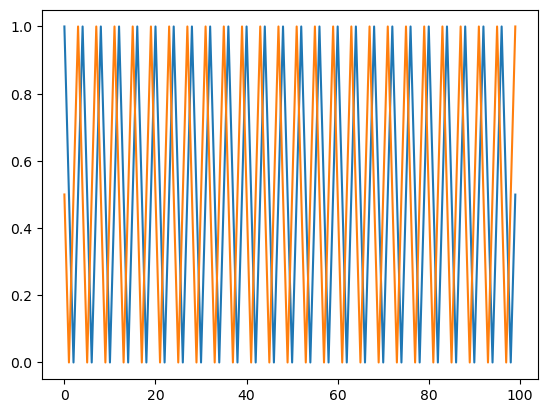

In [36]:
plt.plot(probs_inphase[0])
plt.plot(probs_quadrature[0])

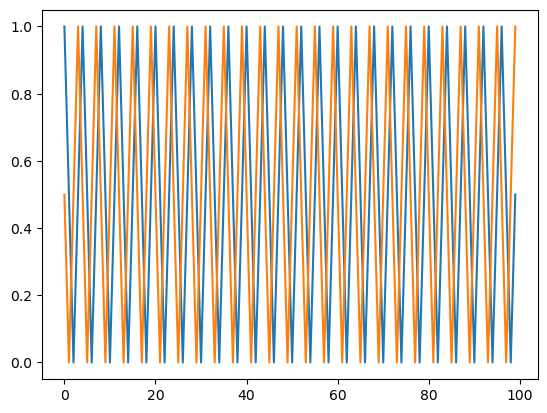

In [37]:
plt.plot(probs_inphase[1])
plt.plot(probs_quadrature[1])

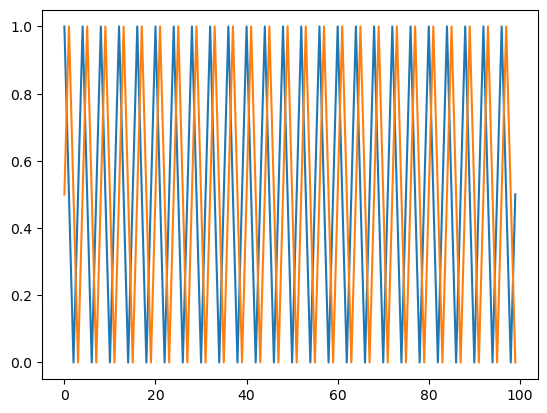

In [38]:
plt.plot(probs_inphase[2])
plt.plot(probs_quadrature[2])

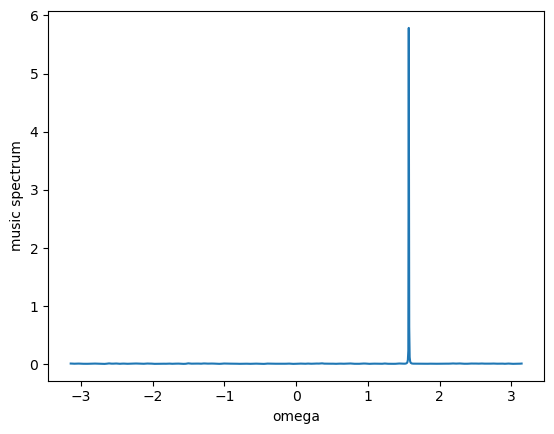

In [39]:
music_spectrum = MusicSpectrum(probs_inphase[0], probs_quadrature[0], [i for i in range(100)], num_sources=1, decay=0.0)
music_spectrum.show_spectrum_at_max_depth_idx()

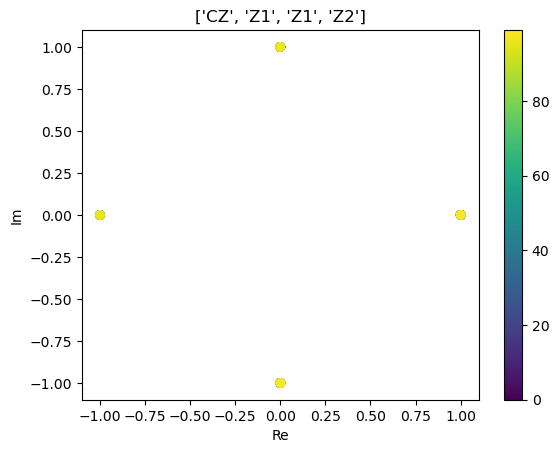

In [40]:
def plot_complex_signal(cos_series, sin_series, depths, germ_hash):
    # plot the real and imaginary part in the complex plane
    # signal is a numpy array of complex numbers
    # use a color map to indicate the depth
    signal = (1-2*cos_series) + 1j*(1-2*sin_series)
    plt.figure()
    plt.scatter(np.real(signal), np.imag(signal), c=depths, cmap='viridis')
    plt.xlabel('Re')
    plt.ylabel('Im')
    plt.title(germ_hash)
    plt.colorbar()
    plt.show()

plot_complex_signal(probs_inphase[0], probs_quadrature[0], [i for i in range(100)], optimal_germs[0])

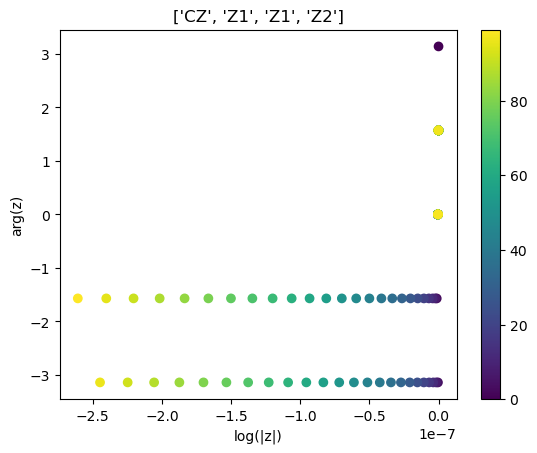

In [41]:
def plot_log_complex_signal(cos_series, sin_series, depths, germ_hash):
    # plot the real and imaginary part in the complex plane
    # signal is a numpy array of complex numbers
    # use a color map to indicate the depth
    signal = (1-2*cos_series) + 1j*(1-2*sin_series)
    plt.scatter(np.log(np.abs(signal)), np.angle(signal), c=depths, cmap='viridis')
    plt.xlabel('log(|z|)')
    plt.ylabel('arg(z)')
    plt.title(germ_hash)
    plt.colorbar()
    plt.show()

plot_log_complex_signal(probs_inphase[0], probs_quadrature[0], [i for i in range(100)], optimal_germs[0])

In [270]:
class ParametricEstimator:
    def __init__(self, cos_prob_series, sin_prob_series, depths):
        self.signal = (1 - 2*cos_prob_series) + 1j*(1 - 2*sin_prob_series)
        self.depths = depths

    def model(decay, phase, depths):
        return np.exp(-decay*depths)*np.exp(1j*phase*depths)

    def estimate(self):
        logs = np.log(self.signal)



In [271]:
estimator = ParametricEstimator(probs_inphase[0], probs_quadrature[0], [i for i in range(100)])
slope, intercept = estimator.estimate()
print(slope, intercept)

TypeError: cannot unpack non-iterable NoneType object

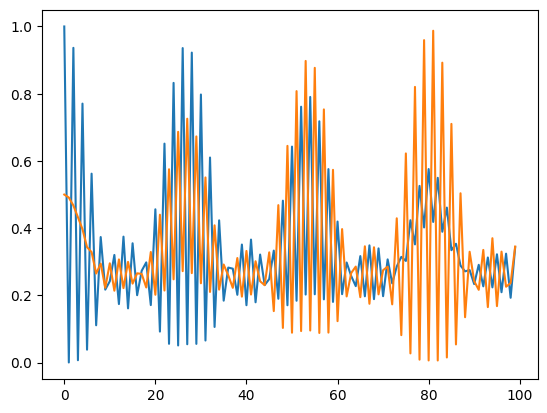

In [275]:
plt.plot(probs_inphase[2])
plt.plot(probs_quadrature[2])

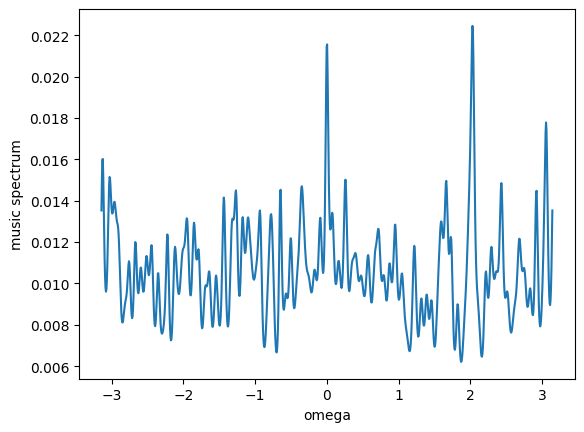

In [276]:
spectrum = MusicSpectrum(probs_inphase[2], probs_quadrature[2], depths, num_sources=2)
spectrum.show_spectrum_at_max_depth_idx()

In [277]:
def rectify_phase(phase):
    return np.mod(phase, 2*np.pi)

In [278]:
x = 0.01*np.random.randn(15)

In [279]:
estimate_cartan_coefs_of_germ(0.1*np.random.randn(15), optimal_germs[4], [2**i for i in range(24)], 1000)

[ 1.00000000e+00+0.00000000e+00j -1.74315280e-32+0.00000000e+00j
 -3.92523115e-17+0.00000000e+00j -5.88784672e-17+3.92523115e-17j] [ 0.5       +1.53080850e-17j  0.5       +1.11022302e-16j
 -0.35355339+3.53553391e-01j  0.35355339+3.53553391e-01j] [ 1.08947050e-32+3.06161700e-17j  1.00000000e+00+0.00000000e+00j
 -7.85046229e-17+7.85046229e-17j  0.00000000e+00-1.96261557e-17j]
[ 5.00000000e-01+5.00000000e-01j -1.11022302e-16-1.11022302e-16j
 -3.53553391e-01-3.53553391e-01j -3.53553391e-01-3.53553391e-01j] [ 5.00000000e-01-1.14967359e-17j -1.74315280e-32+5.00000000e-01j
 -1.37383090e-16+0.00000000e+00j -3.92523115e-17+7.07106781e-01j] [-2.68048208e-17+2.68048208e-17j  5.00000000e-01+5.00000000e-01j
 -3.53553391e-01+3.53553391e-01j  3.53553391e-01-3.53553391e-01j]


([array([3.07170665, 3.14275274, 3.09475271, 3.10543085, 3.09374556,
         3.08979169, 3.09388221, 3.09384569, 3.09394317, 3.09352855,
         3.09343909, 3.09339845, 3.09335815, 3.09336204, 3.09335933,
         3.09335764, 3.09335674, 3.09335661, 3.09335656, 3.09335655,
         3.09335628, 3.09335636, 3.09335636, 3.09335634]),
  array([1.65727366, 1.60174846, 1.6460933 , 1.65436483, 1.65920293,
         1.65703425, 1.65940165, 1.65900539, 1.6585031 , 1.65871033,
         1.65864205, 1.65862478, 1.65865351, 1.65864626, 1.65865236,
         1.6586482 , 1.65864696, 1.6586474 , 1.65864781, 1.65864759,
         1.65864766, 1.65864764, 1.65864765, 1.65864767]),
  array([3.12745218, 3.17763513, 3.16009587, 3.15964785, 3.15998615,
         3.16040401, 3.15999481, 3.15950434, 3.15929571, 3.15938549,
         3.15936354, 3.15939626, 3.15939447, 3.15939941, 3.15940283,
         3.15940032, 3.15940118, 3.15940063, 3.15940067, 3.15940063,
         3.1594007 , 3.15940063, 3.15940064, 3.1594006

In [280]:
depths = np.array([2**i for i in range(18)])

for germ in optimal_germs:
    print(germ)
    estimate, lgg = estimate_cartan_coefs_of_germ(x, germ, depths, 1000)
    print(estimate[0][-1], estimate[1][-1], estimate[2][-1])
    print(rectify_phase(extract_cartan_params(germ, x)))
    print(lgg)



['CZ']
[0.70710678+0.j 0.70710678+0.j 0.        +0.j 0.        +0.j] [0.        +0.j 0.70710678+0.j 0.70710678+0.j 0.        +0.j] [0.        +0.j 0.        +0.j 0.70710678+0.j 0.70710678+0.j]
[0.70710678+0.j         0.        +0.70710678j 0.        +0.j
 0.        +0.j        ] [0.        +0.j         0.70710678+0.j         0.        +0.70710678j
 0.        +0.j        ] [0.        +0.j         0.        +0.j         0.70710678+0.j
 0.        +0.70710678j]
6.203691876221938 0.029978267313757495 3.166258028962922
[6.26087832 6.27557786 3.15174214]
[5, 13, 11]
('CZ', 'X2', 'X2', 'Y1')
[ 1.00000000e+00+0.00000000e+00j -3.92523115e-17+5.88784672e-17j
 -1.30736460e-32+8.71576399e-33j  3.92523115e-17+7.85046229e-17j] [0.5       +1.55006844e-17j 0.35355339-3.53553391e-01j
 0.5       +7.05952294e-17j 0.35355339+3.53553391e-01j] [1.20830777e-17+3.10013688e-17j 7.85046229e-17-1.17756934e-16j
 1.00000000e+00+0.00000000e+00j 1.96261557e-17+2.35513869e-16j]
[ 5.00000000e-01+5.00000000e-01j -3.5355

In [281]:
def angle_difference(angle1, angle2):
  """Calculates the smallest difference between two angles in radians.

  Args:
    angle1: The first angle in radians.
    angle2: The second angle in radians.

  Returns:
    The smallest difference between the two angles in radians.
  """
  diff = np.mod(angle2 - angle1 + np.pi, 2 * np.pi) - np.pi
  return diff


In [282]:
def model_loss(x, germs, cartain_coef_estimates):
        loss = 0
        for germ, est in zip(germs, cartan_coef_estimates):
            for i in range(3):
                loss += angle_difference(extract_cartan_params(germ, x)[i], est[i])**2
        return loss 

def recover_model_params(germs, cartan_coef_estimates):
    
    
    from scipy.optimize import minimize
    x0 = np.zeros(15)
    bounds = [(-0.2, 0.2) for i in range(15)]
    res = minimize(model_loss, x0, args=(germs, cartan_coef_estimates), bounds=bounds)
    return res
    

In [283]:
cartan_coef_estimates = np.zeros((len(optimal_germs), 3))
for idx, germ in enumerate(optimal_germs):
    eseries = estimate_cartan_coefs_of_germ(x, germ, depths, 100)[0]
    for i in range(3):
        cartan_coef_estimates[idx, i] = eseries[i][-1]

[0.70710678+0.j 0.70710678+0.j 0.        +0.j 0.        +0.j] [0.        +0.j 0.70710678+0.j 0.70710678+0.j 0.        +0.j] [0.        +0.j 0.        +0.j 0.70710678+0.j 0.70710678+0.j]
[0.70710678+0.j         0.        +0.70710678j 0.        +0.j
 0.        +0.j        ] [0.        +0.j         0.70710678+0.j         0.        +0.70710678j
 0.        +0.j        ] [0.        +0.j         0.        +0.j         0.70710678+0.j
 0.        +0.70710678j]
[ 1.00000000e+00+0.00000000e+00j -3.92523115e-17+5.88784672e-17j
 -1.30736460e-32+8.71576399e-33j  3.92523115e-17+7.85046229e-17j] [0.5       +1.55006844e-17j 0.35355339-3.53553391e-01j
 0.5       +7.05952294e-17j 0.35355339+3.53553391e-01j] [1.20830777e-17+3.10013688e-17j 7.85046229e-17-1.17756934e-16j
 1.00000000e+00+0.00000000e+00j 1.96261557e-17+2.35513869e-16j]
[ 5.00000000e-01+5.00000000e-01j -3.53553391e-01+3.53553391e-01j
 -7.05952294e-17-7.05952294e-17j -3.53553391e-01+3.53553391e-01j] [ 5.00000000e-01+9.62888119e-18j  7.07106781e

In [284]:
cartan_coef_estimates

array([[6.20369442, 0.03031367, 3.16692948],
       [3.1552278 , 4.68180765, 3.15816095],
       [3.14156869, 4.69919342, 3.13667667],
       [3.13004934, 1.57736444, 3.11743653],
       [3.15165634, 1.55220803, 3.14619092]])

In [285]:
res = recover_model_params(optimal_germs, cartan_coef_estimates)

In [286]:
res.x

array([-0.00551767,  0.03475333, -0.02746756,  0.00387361,  0.01873814,
       -0.02011406, -0.01417852,  0.01971641,  0.00589597,  0.01334836,
       -0.02850011, -0.00059142, -0.00658998, -0.03442121, -0.05182208])

In [48]:
x

array([ 1.07362345e-03,  3.99111614e-03, -8.43890558e-03, -3.78958107e-03,
        7.50232738e-03, -8.71651339e-03, -2.71296502e-03,  2.30296102e-03,
        2.19376232e-03, -6.84769803e-05, -1.46890692e-02,  7.07885040e-03,
       -1.27227943e-02,  1.39407972e-03, -1.74809081e-02])

In [49]:
res.fun

29.13893840778735

In [50]:
model_loss(x, optimal_germs, cartan_coef_estimates)

34.58330295353669

# Finding the fiducials

In [51]:
def find_nonentangled_inphase_state_prep_vectors(germ):
    target_u = germ_to_target(germ)
    evals_targ, evecs_targ = np.linalg.eig(target_u)
    evec_targ_list = [evecs_targ[:,i] for i in range(4)]
    indices = []
    for i in range(4):
        for j in range(i+1, 4):
            psi_ij = (evec_targ_list[i] + evec_targ_list[j])/np.sqrt(2)
            if check_if_entangled(psi_ij) is False:
                indices.append((i, j))
    return indices

def find_nonentangled_quadrature_state_prep_vectors(germ):
    target_u = germ_to_target(germ)
    evals_targ, evecs_targ = np.linalg.eig(target_u)
    evec_targ_list = [evecs_targ[:,i] for i in range(4)]
    indices = []
    for i in range(4):
        for j in range(i+1, 4):
            psi_ij = (evec_targ_list[i] + 1j*evec_targ_list[j])/np.sqrt(2)
            if check_if_entangled(psi_ij) is False:
                indices.append((i, j))
    return indices

In [52]:
for germ in optimal_germs:
    print(find_nonentangled_inphase_state_prep_vectors(germ))

for germ in optimal_germs:
    print(germ, find_nonentangled_quadrature_state_prep_vectors(germ))

NameError: name 'check_if_entangled' is not defined

In [ ]:
def schmidt_rank(state_vector):
    """
    Calculates the Schmidt rank of a state vector.

    Args:
    state_vector: The state vector as a numpy array. 
                    It should be reshaped to a 2D array representing a matrix 
                    if the state vector describes a bipartite system.

    Returns:
    The Schmidt rank of the state vector.
    """

    # Calculate the Singular Value Decomposition (SVD)
    mat = state_vector.reshape((int(np.sqrt(len(state_vector))), int(np.sqrt(len(state_vector)))))
    U, S, V = np.linalg.svd(mat)
    # The Schmidt rank is the number of non-zero singular values
    schmidt_rank = np.sum(S > 1e-10)  # Using a small tolerance to account for numerical errors

    return schmidt_rank

def check_if_entangled(psi):
    """
    Check if a state is entangled
    by calculating the Schmidt rank
    """
    schmidt_rank_psi = schmidt_rank(psi)

    if schmidt_rank_psi == 1:
        return False
    else:
        return True



In [ ]:
for germ in optimal_germs:
    for psi in construct_inphase_state_prep_vectors(germ):
        print(check_if_entangled(psi))

False
True
False
False
True
False
False
True
False
False
True
False
False
True
False


In [ ]:
for germ in optimal_germs:
    for psi in construct_quadrature_state_prep_vectors(germ):
        print(germ, check_if_entangled(psi))

['CZ'] False
['CZ'] True
['CZ'] False
('CZ', 'X2', 'X2', 'Y1') True
('CZ', 'X2', 'X2', 'Y1') True
('CZ', 'X2', 'X2', 'Y1') True
('Y1', 'Y2', 'Y2', 'CZ') True
('Y1', 'Y2', 'Y2', 'CZ') True
('Y1', 'Y2', 'Y2', 'CZ') True
('X1', 'X1', 'Y2', 'CZ') True
('X1', 'X1', 'Y2', 'CZ') True
('X1', 'X1', 'Y2', 'CZ') True
('CZ', 'Y2', 'Y1', 'Y1') True
('CZ', 'Y2', 'Y1', 'Y1') True
('CZ', 'Y2', 'Y1', 'Y1') True


In [ ]:
def make_zxzxz_unitary_1q(phases):
    u = np.eye(2)
    u = expm(-1j*phases[0]*SigZ/2) @ u
    u = expm(-1j*np.pi*SigX/4) @ u
    u = expm(-1j*phases[1]*SigZ/2) @ u
    u = expm(-1j*np.pi*SigX/4) @ u
    u = expm(-1j*phases[2]*SigZ/2) @ u
    return u

def kak_prep_synthesis(target_state):
    """
    Synthesize a preparation circuit for a target state
    using the KAK decomposition
    """
    

def separable_prep_cost(phases, target_state):
    U_Q1 = make_zxzxz_unitary_1q(phases[0:3])
    U_Q2 = make_zxzxz_unitary_1q(phases[3:6])
    U = np.kron(U_Q1, U_Q2)
    U_prep = U@np.array([1, 0, 0, 0])
    return 1 - abs(np.dot(U_prep.conj().T, target_state))**2

def entangled_state_cost(phases, target_state):
    target_cz = model_CZ(np.zeros(15))
    U_Q1_1 = make_zxzxz_unitary_1q(phases[0:3])
    U_Q2_1 = make_zxzxz_unitary_1q(phases[3:6])
    K_1 = np.kron(U_Q1_1, U_Q2_1)
    U_Q1_2 = make_zxzxz_unitary_1q(phases[6:9])
    U_Q2_2 = make_zxzxz_unitary_1q(phases[9:12])
    K_2 = np.kron(U_Q1_2, U_Q2_2)
    U = K_2 @ target_cz @ K_1
    prep_from_U = U @ np.array([1, 0, 0, 0])
    return 1 - abs(np.dot(prep_from_U.conj().T, target_state))**2

def double_cz_gate_state_prep_cost(phases, target_state):
    target_cz = model_CZ(np.zeros(15))
    U_Q1_1 = make_zxzxz_unitary_1q(phases[0:3])
    U_Q2_1 = make_zxzxz_unitary_1q(phases[3:6])
    K_1 = np.kron(U_Q1_1, U_Q2_1)
    U_Q1_2 = make_zxzxz_unitary_1q(phases[6:9])
    U_Q2_2 = make_zxzxz_unitary_1q(phases[9:12])
    K_2 = np.kron(U_Q1_2, U_Q2_2)
    U_Q1_3 = make_zxzxz_unitary_1q(phases[12:15])
    U_Q2_3 = make_zxzxz_unitary_1q(phases[15:18])
    K_3 = np.kron(U_Q1_2, U_Q2_2)
    U = K_2 @ target_cz @ K_1 @ target_cz @ K_3
    prep_from_U = U @ np.array([1, 0, 0, 0])
    return 1 - abs(np.dot(prep_from_U.conj().T, target_state))**2


def find_preparation_circuit(target_state):
    """
    Find a circuit that prepares a target state

    use an optimization algorithm to find the best,
    bound the phases between [0, 2pi]
    """
    from scipy.optimize import minimize
    if check_if_entangled(target_state) is False:
        bounds = [(0, 2*np.pi) for i in range(6)]
        res = minimize(state_cost, np.random.rand(6), args=(target_state), bounds=bounds)
    else:
        bounds = [(0, 2*np.pi) for i in range(12)]
        res = minimize(entangled_state_cost, np.random.rand(12), args=(target_state), bounds=bounds)
        if res.fun > 1e-3:
            bounds = [(0, 2*np.pi) for i in range(18)]
            res = minimize(double_cz_gate_state_prep_cost, np.random.rand(18), args=(target_state), bounds=bounds)
    return res.x, res.fun
    

In [ ]:
inphase_state_preps = [construct_inphase_state_prep_vectors(germ) for germ in optimal_germs]
quadrature_state_preps = [construct_quadrature_state_prep_vectors(germ) for germ in optimal_germs]

In [ ]:
find_preparation_circuit(inphase_state_preps[0][1])

(array([5.36194497e-01, 1.57081172e+00, 0.00000000e+00, 2.08751982e-01,
        1.57079123e+00, 0.00000000e+00, 8.25839581e-06, 7.96325977e-01,
        3.72027977e-01, 0.00000000e+00, 7.74480485e-01, 3.72015889e-01]),
 1.1005218958359819e-10)

In [ ]:
all_inphase_preps = [prep for preps in inphase_state_preps for prep in preps]
all_quadrature_preps = [prep for preps in quadrature_state_preps for prep in preps]
for prep in all_inphase_preps:
    print(find_preparation_circuit(prep)[1])
for prep in all_quadrature_preps:
    print(find_preparation_circuit(prep)[1])

7.216449660063518e-14
9.727996186370547e-12
0.0
1.7896795156957523e-13
1.2185852327206703e-10
6.41908748377773e-12
8.228306924706885e-12
7.29178939451458e-11
8.881784197001252e-16
9.985656745925553e-11
1.773470259536225e-12
1.3322676295501878e-15
9.976464099281657e-13
6.459386359125574e-10
0.0
2.1449508835758024e-13
2.719402480977351e-11
5.706546346573305e-14
5.367351008089827e-11
8.994582856303168e-12
2.967692758204521e-11
1.0190359667205939e-10
7.832601234269987e-11
1.1800005417228476e-10
4.2056802485035405e-11
1.907762836594884e-11
1.339472976980005e-10
4.933720099131733e-11
1.7998580403855158e-10
2.134470378223341e-11
